<a href="https://colab.research.google.com/github/cody-plans/transit-safety-insights/blob/logistic-regression-model-revised/log_reg_model_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Title: Major Incident Classification Pipeline with Logistic Regression
Description:
    This script performs the following steps:
      1. Loads the raw transit safety dataset.
      2. Cleans the data by selecting columns, handling missing values, and removing duplicates.
      3. Engineers additional features from date/time information and census data (UACE and Density).
      4. Constructs a model pipeline:
           - Defines the target variable ("Major_Incident")
           - Removes columns used to define the target and performs correlation-based feature selection.
           - One-hot encodes categorical variables.
           - Balances the dataset via oversampling.
           - Trains a logistic regression model with hyperparameter tuning using GridSearchCV.
      5. Evaluates the fitted model using various metrics and visualizations.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn & imbalanced-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)


In [2]:
# =============================================================================
# STEP 0: Download Raw Data
# =============================================================================

def download_raw_data():
    # Download the dataset from data.transportation.gov

    # Create a directory for the data
    !mkdir -p data

    # Download the dataset from data.transportation.gov
    !wget -O data/raw_data.csv "https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD"

In [3]:
# =============================================================================
# STEP 1: Load Raw Data
# =============================================================================
def load_raw_data():
    # Uncomment the following line if running in Jupyter Notebook:
    # %matplotlib inline
    sns.set(style="whitegrid")

    data_path = "/content/data/raw_data.csv"
    df = pd.read_csv(data_path)

    # Display first few rows and column names for inspection
    print("[INFO] Raw data preview:")
    print(df.head())
    print("\n[INFO] Raw data columns:")
    print(df.columns.tolist())

    return df


In [4]:
# =============================================================================
# STEP 2: Preprocess Dataset
# =============================================================================
def process_features(df):
    """
    Process the raw dataframe and return features (X_resampled) and target (y_resampled)
    after performing the following steps:

      1. Target Variable Definition (Major_Incident)
      2. Feature Extraction and Enhancement
         a. Time/Date Conversion and Derived Temporal Features
         b. UACE to Density Conversion (via Census data merge)
      3. Columns to Keep (Judgemental, Missing Value, Statistical)
         a. Retain only a defined list of columns (judgemental selection)
         b. Drop features with excessive missing values and then remove any remaining missing rows and duplicates
         c. Statistical filtering: Drop low-correlated numeric features
      4. Categorical Columns Encoding
      5. Address Class Imbalance via Oversampling

    Returns:
      X_resampled: Processed feature DataFrame after oversampling.
      y_resampled: Target variable Series after oversampling.
    """
    # -------------------------------------------------------------------------
    # 1. Target Variable Definition (Major_Incident)
    # -------------------------------------------------------------------------
    DAMAGE_THRESHOLD = 25000
    df["Major_Incident"] = df.apply(
        lambda row: 1 if (
            row.get("Total Serious Injuries", 0) > 0 or
            row.get("Total Fatalities", 0) > 0 or
            row.get("Property Damage", 0) > DAMAGE_THRESHOLD
        ) else 0,
        axis=1
    )
    print("[INFO] Defined target 'Major_Incident'.")

    # -------------------------------------------------------------------------
    # 2. Feature Extraction and Enhancement
    # -------------------------------------------------------------------------
    # 2a. Time/Date Conversion and Derived Temporal Features
    df['Event Date'] = pd.to_datetime(df['Event Date'], format='%Y %B %d', errors='coerce')
    df['Event Time'] = pd.to_datetime(df['Event Time'].astype(str), errors='coerce').dt.time

    # Extract additional date features
    df['Month'] = df['Event Date'].dt.month
    df['Day'] = df['Event Date'].dt.day
    df['Weekday'] = df['Event Date'].dt.day_name()
    df['Season'] = df['Month'].apply(lambda m: 'winter' if m in [12, 1, 2] else 'non-winter')

    # Extract hour from 'Event Time'
    df['Hour'] = df['Event Time'].apply(lambda t: t.hour if pd.notnull(t) else None)

    # Categorize time of day into segments
    def categorize_time(hour):
        if hour is None:
            return None
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'
    df['Time Of Day'] = df['Hour'].apply(categorize_time)

    # Create a rush hour flag (1 if during rush hours, else 0)
    def is_rush_hour(hour):
        if hour is None:
            return 0
        return 1 if (7 <= hour < 10 or 16 <= hour < 19) else 0
    df['Rush Hour'] = df['Hour'].apply(is_rush_hour)
    print("[INFO] Time/Date features engineered.")

    # 2b. UACE to Density Conversion (if applicable)
    # Load census data (assumed to be in CSV format)
    census_path = "/content/data/census_data_2010.csv"
    df_census = pd.read_csv(census_path)

    # Compute density: Density = POP / (AREALAND/1000)
    df_census['Density'] = df_census['POP'] / df_census['AREALAND'] * 1000
    # Normalize density to a [0, 1] range
    density_min = df_census['Density'].min()
    density_max = df_census['Density'].max()
    df_census['Density'] = (df_census['Density'] - density_min) / (density_max - density_min)

    # Retain only the necessary census columns for merging
    df_census_subset = df_census[['UACE', 'Density']]
    # Merge census data with the main DataFrame using the UACE code
    df = pd.merge(df, df_census_subset, left_on='Primary UZA UACE Code', right_on='UACE', how='left')
    print("[INFO] Census data merged and normalized density computed.")

    # -------------------------------------------------------------------------
    # 3. Columns to Keep (Judgemental, Missing Value, Statistical)
    # -------------------------------------------------------------------------
    # 3a. Judgemental: Retain only a defined list of columns
    # (Note: Columns used solely for target definition such as 'Total Serious Injuries',
    #  'Total Fatalities', and 'Property Damage' are omitted)
    columns_to_keep = [
        'NTD ID',
        'Rail/Bus/Ferry',
        'Mode Name',
        'Mode',
        'TOS',
        'Year',
        'Event Type',
        'Event Type Group',
        'Safety/Security',
        'Towed (Y/N)',
        'Number of Transit Vehicles Involved',
        'Number of Non-Transit Vehicles Involved',
        'Number of Cars on Involved Transit Vehicles',
        'Non-Transit Vehicle Type List',
        'Location Type',
        'Latitude',
        'Longitude',
        'Weather',
        'Lighting',
        'Road Configuration',
        'Path Condition',
        'Right of Way Condition',
        'Intersection Control Device',
        'Transit Vehicle Action',
        'Other Transit Vehicle Action Description',
        'Non-Transit Vehicle Action List',
        'Transit (Y/N)',
        'Fuel Type',
        'Vehicle Speed',
        'Transit Vehicle Type',
        'Non-Transit Vehicle Type',
        'Transit Vehicle Manufacturer',
        # Include engineered features
        'Month', 'Day', 'Weekday', 'Season', 'Hour', 'Time Of Day', 'Rush Hour', 'Density',
        'Major_Incident'
    ]
    columns_to_keep = [col for col in columns_to_keep if col in df.columns]
    df = df[columns_to_keep]
    print("[INFO] Retained judgemental columns:", df.columns.tolist())

    # 3b. Missing Value Handling: Drop features with >10% missing values, then drop remaining missing rows and duplicates
    missing_counts = df.isnull().sum()
    cols_to_drop = missing_counts[missing_counts > 0.1 * df.shape[0]].index.tolist()
    if cols_to_drop:
        print("[INFO] Dropping columns with >10% missing values:", cols_to_drop)
        df.drop(columns=cols_to_drop, inplace=True)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    print("[INFO] Data shape after missing value and duplicate removal:", df.shape)

    # 3c. Statistical Filtering: Drop numeric features with low correlation to target
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if "Major_Incident" in numeric_cols:
        corr_matrix = df[numeric_cols].corr()
        target_corr = corr_matrix["Major_Incident"].drop("Major_Incident")
        low_corr_features = target_corr[abs(target_corr) < 0.05].index.tolist()
        if low_corr_features:
            df.drop(columns=low_corr_features, inplace=True)
            print("[INFO] Dropped low-correlation numeric features:", low_corr_features)
        else:
            print("[INFO] No low-correlation numeric features to drop.")
    else:
        print("[WARNING] 'Major_Incident' not found in numeric features for correlation analysis.")

    # -------------------------------------------------------------------------
    # 4. Categorical Columns Encoding
    # -------------------------------------------------------------------------
    categorical_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
    print("[INFO] Categorical columns to encode:", categorical_columns)
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    print("[INFO] Data shape after one-hot encoding:", df_encoded.shape)

    # -------------------------------------------------------------------------
    # 5. Address Class Imbalance via Oversampling
    # -------------------------------------------------------------------------
    X = df_encoded.drop(columns=["Major_Incident"])
    y = df_encoded["Major_Incident"]
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print("[INFO] Class distribution after oversampling:")
    print(pd.Series(y_resampled).value_counts())

    return X_resampled, y_resampled

# =============================================================================
# Example Usage:
# =============================================================================
# Load your raw data into a DataFrame (e.g., from a CSV file)
# df_raw = pd.read_csv("your_data.csv")
# X_processed, y_processed = process_features(df_raw)


In [5]:
# =============================================================================
# STEP 3: Build and Train Model
# =============================================================================
def build_and_train_model(X, y):
    """
    Build and train a regularized logistic regression model using GridSearchCV.

    This function assumes that X and y have been preprocessed and oversampled by process_features,
    so that all steps such as target definition, feature extraction, encoding, and oversampling have been completed.

    Steps:
      1. Split the data into training and testing sets.
      2. Use GridSearchCV to train and tune a Logistic Regression model.
      3. Evaluate the model on the test set.

    Returns:
      best_lr: Best logistic regression estimator from grid search.
      X_train, X_test, y_train, y_test: Train/test splits.
    """
    # Split the already processed data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize Logistic Regression model
    lr = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000, random_state=42)
    param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

    # Set up GridSearchCV to tune the regularization parameter
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring="f1", verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_lr = grid_search.best_estimator_
    print("[INFO] Best regularization parameter C:", grid_search.best_params_["C"])
    print("[INFO] Best cross-validation F1 score:", grid_search.best_score_)

    # Evaluate the model on the test set
    test_score = best_lr.score(X_test, y_test)
    print("[INFO] Test set score:", test_score)

    return best_lr, X_train, X_test, y_train, y_test


In [6]:
# =============================================================================
# STEP 4: Evaluate the Fitted Model
# =============================================================================
def evaluate_model(best_lr, X_test, y_test, X_train):
    # --- Predictions and Metrics ---
    y_pred = best_lr.predict(X_test)
    y_proba = best_lr.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\n=== Model Performance Metrics ===")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Major", "Major"],
                yticklabels=["Non-Major", "Major"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --- Classification Report ---
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred))

    # --- ROC Curve and AUC ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC:", roc_auc)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # --- Feature Importance ---
    feature_names = X_train.columns
    coefficients = best_lr.coef_[0]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients,
        "Absolute Coefficient": np.abs(coefficients)
    })

    coef_df_sorted = coef_df.sort_values(by="Absolute Coefficient", ascending=False)
    print("\n=== Top 10 Explanatory Variables ===")
    print(coef_df_sorted.head(10))

    plt.figure(figsize=(8, 6))
    top_10 = coef_df_sorted.head(10)
    plt.barh(top_10["Feature"], top_10["Coefficient"])
    plt.xlabel("Coefficient Value")
    plt.title("Top 10 Explanatory Variables in Logistic Regression")
    plt.gca().invert_yaxis()  # Largest coefficients on top
    plt.tight_layout()
    plt.show()

    # --- Importance of Specific Features ---
    keywords = ["Weekday", "Season", "Time Of Day", "Density"]
    selected_features = coef_df[coef_df["Feature"].apply(lambda x: any(keyword in x for keyword in keywords))]
    selected_features = selected_features.sort_values(by="Absolute Coefficient", ascending=False)

    print("\nImportance of features 'Weekday', 'Season', 'Time Of Day', and 'Density':")
    print(selected_features)

    plt.figure(figsize=(8, 6))
    plt.barh(selected_features["Feature"], selected_features["Coefficient"])
    plt.xlabel("Coefficient Value")
    plt.title("Importance of Specific Time/Area Features")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()




--2025-03-21 19:05:52--  https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.transportation.gov (data.transportation.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/raw_data.csv’

data/raw_data.csv       [          <=>       ]  91.30M  5.30MB/s    in 16s     

2025-03-21 19:06:09 (5.58 MB/s) - ‘data/raw_data.csv’ saved [95738829]



<ipython-input-3-61dd2a500d63>:10: DtypeWarning: Columns (18,20,24,34,38,45,46,49,53,54,60,63,64,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


[INFO] Raw data preview:
   NTD ID                                             Agency  \
0   20080                     New Jersey Transit Corporation   
1   40035  Central Florida Regional Transportation Authority   
2   50027                                      Metro Transit   
3   90026              San Diego Metropolitan Transit System   
4   20080                     New Jersey Transit Corporation   

   Primary UZA UACE Code Rail/Bus/Ferry        Mode Name Mode TOS  \
0                  63217            Bus              Bus   MB  DO   
1                  65863            Bus  Demand Response   DR  DO   
2                  57628           Rail       Light Rail   LR  DO   
3                  78661           Rail       Light Rail   LR  DO   
4                  63217            Bus              Bus   MB  DO   

   Fixed Route Flag  Year                                  Event Description  \
0              True  2024  Bus was parked in <REDACTED> <REDACTED> and an...   
1             F

<ipython-input-4-c04713911e02>:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Event Time'] = pd.to_datetime(df['Event Time'].astype(str), errors='coerce').dt.time


[INFO] Time/Date features engineered.
[INFO] Census data merged and normalized density computed.
[INFO] Retained judgemental columns: ['NTD ID', 'Rail/Bus/Ferry', 'Mode Name', 'Mode', 'TOS', 'Year', 'Event Type', 'Event Type Group', 'Safety/Security', 'Towed (Y/N)', 'Number of Transit Vehicles Involved', 'Number of Non-Transit Vehicles Involved', 'Number of Cars on Involved Transit Vehicles', 'Non-Transit Vehicle Type List', 'Location Type', 'Latitude', 'Longitude', 'Weather', 'Lighting', 'Road Configuration', 'Path Condition', 'Right of Way Condition', 'Intersection Control Device', 'Transit Vehicle Action', 'Other Transit Vehicle Action Description', 'Non-Transit Vehicle Action List', 'Transit (Y/N)', 'Fuel Type', 'Vehicle Speed', 'Transit Vehicle Type', 'Non-Transit Vehicle Type', 'Transit Vehicle Manufacturer', 'Month', 'Day', 'Weekday', 'Season', 'Hour', 'Time Of Day', 'Rush Hour', 'Density', 'Major_Incident']
[INFO] Dropping columns with >10% missing values: ['Non-Transit Vehicle

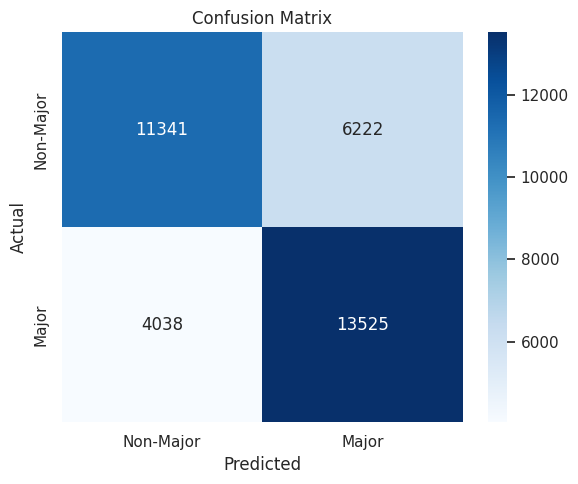


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     17563
           1       0.68      0.77      0.73     17563

    accuracy                           0.71     35126
   macro avg       0.71      0.71      0.71     35126
weighted avg       0.71      0.71      0.71     35126

ROC AUC: 0.7964112481358906


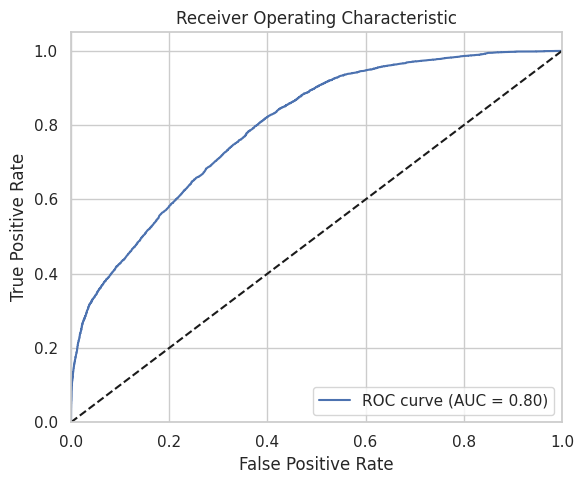


=== Top 10 Explanatory Variables ===
                                              Feature  Coefficient  \
74                      Event Type_Suspicious package    -9.478220   
48                                Event Type_Homicide     9.403901   
24                                            Mode_MB    -8.954588   
38                             Event Type_Bomb Threat    -8.920893   
6                              Mode Name_Commuter Bus    -8.317244   
49     Event Type_Homicide not against Transit Worker     8.123473   
55                     Event Type_Motor Vehicle Theft     7.958398   
41  Event Type_Chemical / Biological / Nuclear / R...    -7.187331   
66        Event Type_Physical Homicide on an Operator     6.293814   
43                              Event Type_Earthquake    -6.106221   

    Absolute Coefficient  
74              9.478220  
48              9.403901  
24              8.954588  
38              8.920893  
6               8.317244  
49              8.123473  
55

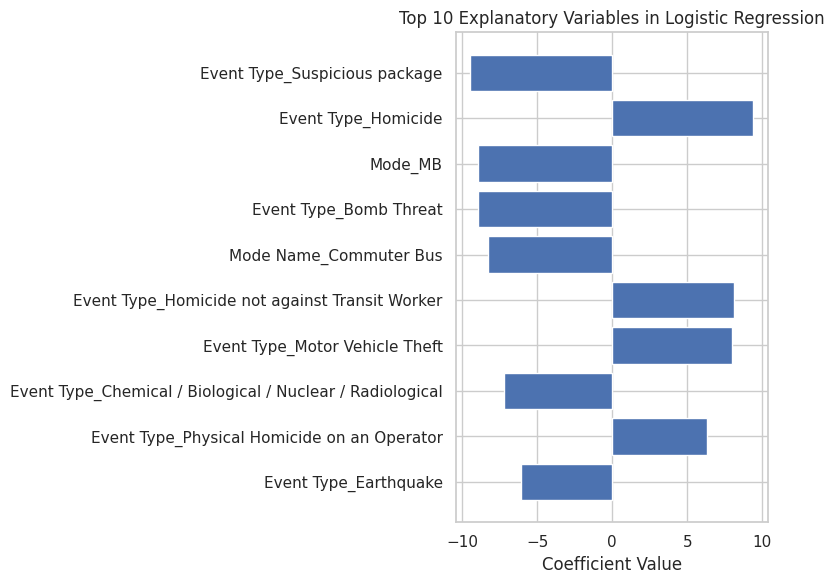


Importance of features 'Weekday', 'Season', 'Time Of Day', and 'Density':
                 Feature  Coefficient  Absolute Coefficient
128    Time Of Day_night     0.361706              0.361706
127  Time Of Day_morning     0.159520              0.159520
126  Time Of Day_evening     0.084435              0.084435
121       Weekday_Sunday    -0.064058              0.064058
122     Weekday_Thursday    -0.063796              0.063796
123      Weekday_Tuesday    -0.060236              0.060236
124    Weekday_Wednesday    -0.055760              0.055760
120     Weekday_Saturday     0.052142              0.052142
119       Weekday_Monday     0.035629              0.035629
125        Season_winter     0.024162              0.024162


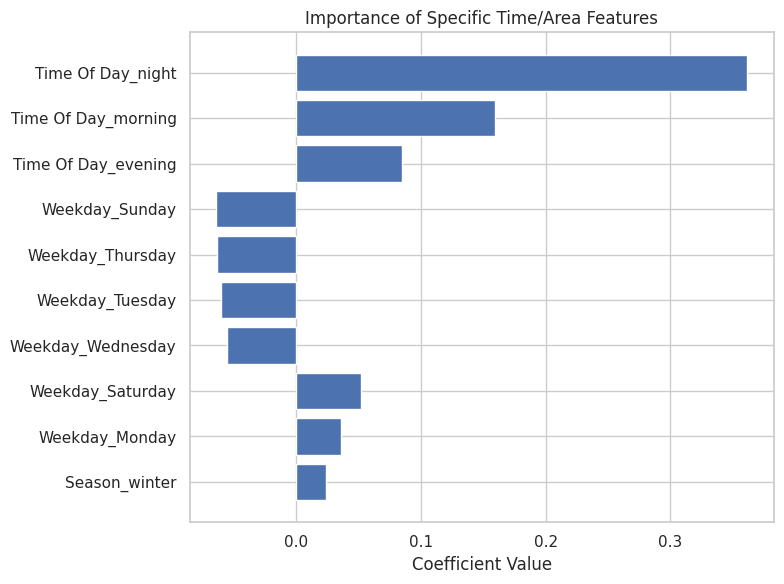

In [8]:
# =============================================================================
# Main Execution
# =============================================================================
def main():
    # Step 0: Download Raw Data (if not already downloaded)
    download_raw_data()

    # Step 1: Load Raw Data
    df_raw = load_raw_data()

    # Step 2: Preprocess and Feature Engineer the Data
    # This step performs target creation, time/date & census engineering, column selection,
    # missing value handling, statistical filtering, one-hot encoding, and oversampling.
    X_resampled, y_resampled = process_features(df_raw)

    # Step 3: Build and Train the Model Pipeline using Processed Data
    best_lr, X_train, X_test, y_train, y_test = build_and_train_model(X_resampled, y_resampled)

    # Step 4: Evaluate the Fitted Model
    evaluate_model(best_lr, X_test, y_test, X_train)

if __name__ == "__main__":
    main()
